In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_dw = pd.read_excel("dw_dominate_data/dw_dominate_house.XLSX")
df_dw = df_dw[['Congress Number', 'Party Code', '1st Dimension Coordinate', '1st Dimension Bootstrapped Standard Error']]
df_dw['Party Code'] = pd.to_numeric(df_dw['Party Code'], errors='coerce')

#filtering out other parties
#100 = Democrats,  200 = Republicans
df_dw = df_dw[df_dw['Party Code'].isin([100, 200])]

#Group by party and congress and calculate average 1_dimension
df_dw["abs_d1"] = df_dw["1st Dimension Coordinate"].abs()
party_avgs = (
    df_dw.groupby(["Congress Number", "Party Code"])          # one group = one party in one Congress
    .agg(avg_abs_d1=("abs_d1", "mean"))                  # rename the column for clarity
    .reset_index()
)

mask = party_avgs["Party Code"].eq(party_avgs["Party Code"].shift(-1))
#congress where only ona party avg is available
congress_same_party = party_avgs.loc[mask, "Congress Number"].tolist()

# keep the rows where the condition is **False**
df_kept = party_avgs.loc[~mask].reset_index(drop=True)
df_kept[df_kept["Congress Number"].between(75, 112)]

# --- Apply Party-Seat Weighting ---
df_seats_partition = pd.read_excel("dw_dominate_data/house_seats.xlsx")
df_seats_partition = df_seats_partition[["Congress Number", "# Seats", "Democrats", "Republicans"]]
df_seats_partition = df_seats_partition[df_seats_partition["Congress Number"].between(76, 111)]

# df1 and df2 each have a column called "Congress Number"
df_merged = pd.merge(
    df_kept,                       # left table
    df_seats_partition,                       # right table
    on="Congress Number",      # key column present in *both* tables
    how="inner",               # match-type: inner | left | right | outer
    suffixes=("_x", "_y")      # handles duplicate column names
)

df_merged["Weighted 1-dimension"] = np.where(
    df_merged["Party Code"] == 100,                      # condition
    df_merged["avg_abs_d1"] * df_merged["Democrats"]   / df_merged["# Seats"],   # if Democrat
    df_merged["avg_abs_d1"] * df_merged["Republicans"] / df_merged["# Seats"]    # if Republican
)

# sum the weighted scores within each (Congress, Party) pair
weighted_sum = (
    df_merged.groupby(["Congress Number"], as_index=False)
    ["Weighted 1-dimension"]
    .sum()
    .rename(columns={"Weighted 1-dimension": "weighted_sum"})
)

weighted_sum = weighted_sum.sort_values("Congress Number")

Standardization

In [3]:
#standardization of df-dominate score
array_score = np.array(weighted_sum["weighted_sum"])

score_std = np.std(array_score)
score_mean = np.mean(array_score)

standard_dw_score = (array_score - score_mean)/score_std
standard_dw_score = standard_dw_score.tolist()

## Model accuracy 

model accuracy comparison

In [4]:
# Load the data
models = ["bayes", "lr", "svm"]
base_dir = Path("../logs")
data = {}

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    data[model] = pd.read_csv(model_file)

# Create combined dataframe for easier analysis
metrics = ['accuracy', 'f1_score', 'auc'] # 'auc' to reinsert once the svm has the auc corrected
combined_df = pd.DataFrame()
combined_df['year'] = data['bayes']['year']

for model in models:
    for metric in metrics:
        combined_df[f'{model}_{metric}'] = data[model][metric]
        combined_df[f'{model}_{metric}_std'] = data[model][f'{metric}_std']

print("=== MODEL COMPARISON ANALYSIS ===\n")

# 1. PERFORMANCE DIFFERENCES BETWEEN MODELS
print("1. PERFORMANCE DIFFERENCES BETWEEN MODELS")
print("=" * 50)

def calculate_difference_metrics(model1, model2, metric):
    """Calculate various difference metrics between two models"""
    values1 = combined_df[f'{model1}_{metric}']
    values2 = combined_df[f'{model2}_{metric}']
    
    # Mean Absolute Difference
    mad = np.mean(np.abs(values1 - values2))
    
    # Root Mean Square Difference  
    rmsd = np.sqrt(np.mean((values1 - values2)**2))
    
    # Correlation coefficient
    corr, p_value = pearsonr(values1, values2)
    
    # Trajectory similarity (inverse of variance of differences)
    diff_variance = np.var(values1 - values2)
    trajectory_similarity = 1 / (1 + diff_variance)  # Normalized similarity score
    
    return {
        'MAD': mad,
        'RMSD': rmsd, 
        'Correlation': corr,
        'Correlation_p_value': p_value,
        'Trajectory_Similarity': trajectory_similarity
    }

# Calculate pairwise differences for each metric
model_pairs = list(combinations(models, 2))

for metric in metrics:
    print(f"\n{metric.upper()} - Pairwise Differences:")
    print("-" * 40)
    
    for model1, model2 in model_pairs:
        diff_metrics = calculate_difference_metrics(model1, model2, metric)
        print(f"{model1.upper()} vs {model2.upper()}:")
        print(f"  Mean Absolute Difference: {diff_metrics['MAD']:.4f}")
        print(f"  Root Mean Square Diff:    {diff_metrics['RMSD']:.4f}")
        print(f"  Correlation:              {diff_metrics['Correlation']:.4f} (p={diff_metrics['Correlation_p_value']:.4f})")
        print(f"  Trajectory Similarity:    {diff_metrics['Trajectory_Similarity']:.4f}")
        print()

# 2. OVERALL BEST MODEL ANALYSIS
print("\n2. OVERALL BEST MODEL ANALYSIS")
print("=" * 50)

def calculate_ranking_metrics():
    """Calculate various ranking and dominance metrics"""
    results = {}
    
    for metric in metrics:
        print(f"\n{metric.upper()} Analysis:")
        print("-" * 30)
        
        metric_results = {}
        
        # Get values for each model
        model_values = {}
        for model in models:
            model_values[model] = combined_df[f'{model}_{metric}'].values
        
        # 1. Win Rate (how often each model is best)
        win_counts = {model: 0 for model in models}
        ranks_sum = {model: 0 for model in models}
        dominance_scores = {model: 0 for model in models}
        
        for i in range(len(combined_df)):
            # Get values for this dataset
            dataset_values = [(model, model_values[model][i]) for model in models]
            # Sort by performance (descending)
            dataset_values.sort(key=lambda x: x[1], reverse=True)
            
            # Update win count
            winner = dataset_values[0][0]
            win_counts[winner] += 1
            
            # Update ranks (1 = best, 3 = worst)
            for rank, (model, _) in enumerate(dataset_values, 1):
                ranks_sum[model] += rank
                
                # Update dominance score
                if rank == 1:
                    dominance_scores[model] += 3
                elif rank == 2:
                    dominance_scores[model] += 1
                else:  # rank == 3
                    dominance_scores[model] -= 1
        
        # Calculate averages and percentages
        total_datasets = len(combined_df)
        
        print("Win Rates:")
        for model in models:
            win_rate = (win_counts[model] / total_datasets) * 100
            print(f"  {model.upper()}: {win_counts[model]}/{total_datasets} datasets ({win_rate:.1f}%)")
        
        print("\nAverage Ranks (lower is better):")
        avg_ranks = {}
        for model in models:
            avg_rank = ranks_sum[model] / total_datasets
            avg_ranks[model] = avg_rank
            print(f"  {model.upper()}: {avg_rank:.2f}")
        
        print("\nDominance Scores (higher is better):")
        for model in models:
            print(f"  {model.upper()}: {dominance_scores[model]}")
        
        # 3. Risk-Adjusted Performance (Mean / Std)
        print("\nRisk-Adjusted Performance (Mean/Std - higher is better):")
        for model in models:
            mean_perf = combined_df[f'{model}_{metric}'].mean()
            std_perf = combined_df[f'{model}_{metric}_std'].mean()
            risk_adj = mean_perf / std_perf if std_perf > 0 else float('inf')
            print(f"  {model.upper()}: {risk_adj:.2f} (μ={mean_perf:.4f}, σ={std_perf:.4f})")
        
        # Store results for summary
        metric_results = {
            'win_counts': win_counts,
            'avg_ranks': avg_ranks,
            'dominance_scores': dominance_scores
        }
        results[metric] = metric_results
    
    return results

ranking_results = calculate_ranking_metrics()

# 3. SUMMARY TABLE
print("\n3. SUMMARY TABLE")
print("=" * 50)

summary_df = pd.DataFrame(index=models)

for metric in metrics:
    # Overall mean performance
    for model in models:
        summary_df.loc[model, f'{metric}_mean'] = combined_df[f'{model}_{metric}'].mean()
        summary_df.loc[model, f'{metric}_std_avg'] = combined_df[f'{model}_{metric}_std'].mean()
        summary_df.loc[model, f'{metric}_wins'] = ranking_results[metric]['win_counts'][model]
        summary_df.loc[model, f'{metric}_avg_rank'] = ranking_results[metric]['avg_ranks'][model]

print("\nOverall Performance Summary:")
print(summary_df.round(4))

# 4. FINAL RECOMMENDATION
print("\n4. FINAL RECOMMENDATION")
print("=" * 50)

# Calculate overall winner based on average ranks across all metrics
overall_ranks = {}
for model in models:
    total_rank = sum(ranking_results[metric]['avg_ranks'][model] for metric in metrics)
    overall_ranks[model] = total_rank / len(metrics)

best_model = min(overall_ranks.keys(), key=lambda k: overall_ranks[k])
print(f"\nBased on average ranking across all metrics:")
for model in models:
    print(f"  {model.upper()}: {overall_ranks[model]:.2f} average rank")

print(f"\n🏆 RECOMMENDED MODEL: {best_model.upper()}")
print(f"   (Lowest average rank = most consistent best performer)")

# Additional insights
print(f"\n📊 KEY INSIGHTS:")
most_similar_pair = None
highest_correlation = -1

for model1, model2 in model_pairs:
    acc_corr = calculate_difference_metrics(model1, model2, 'accuracy')['Correlation']
    if acc_corr > highest_correlation:
        highest_correlation = acc_corr
        most_similar_pair = (model1, model2)

print(f"   • Most similar models: {most_similar_pair[0].upper()} & {most_similar_pair[1].upper()} (r={highest_correlation:.3f})")

# Find most volatile model (highest average std)
volatility = {}
for model in models:
    avg_std = np.mean([combined_df[f'{model}_{metric}_std'].mean() for metric in metrics])
    volatility[model] = avg_std

most_volatile = max(volatility.keys(), key=lambda k: volatility[k])
most_stable = min(volatility.keys(), key=lambda k: volatility[k])

print(f"   • Most stable model: {most_stable.upper()} (avg std: {volatility[most_stable]:.4f})")
print(f"   • Most volatile model: {most_volatile.upper()} (avg std: {volatility[most_volatile]:.4f})")

=== MODEL COMPARISON ANALYSIS ===

1. PERFORMANCE DIFFERENCES BETWEEN MODELS

ACCURACY - Pairwise Differences:
----------------------------------------
BAYES vs LR:
  Mean Absolute Difference: 0.0201
  Root Mean Square Diff:    0.0233
  Correlation:              0.9669 (p=0.0000)
  Trajectory Similarity:    0.9998

BAYES vs SVM:
  Mean Absolute Difference: 0.0193
  Root Mean Square Diff:    0.0249
  Correlation:              0.9252 (p=0.0000)
  Trajectory Similarity:    0.9996

LR vs SVM:
  Mean Absolute Difference: 0.0087
  Root Mean Square Diff:    0.0114
  Correlation:              0.9815 (p=0.0000)
  Trajectory Similarity:    0.9999


F1_SCORE - Pairwise Differences:
----------------------------------------
BAYES vs LR:
  Mean Absolute Difference: 0.0267
  Root Mean Square Diff:    0.0310
  Correlation:              0.9625 (p=0.0000)
  Trajectory Similarity:    0.9997

BAYES vs SVM:
  Mean Absolute Difference: 0.0307
  Root Mean Square Diff:    0.0369
  Correlation:              0.

In [29]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load raw accuracy data (before standardization)
models = ["bayes", "lr", "svm"]
base_dir = Path("models_avg_results")
raw_accuracies = []

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    df = pd.read_csv(model_file)
    accuracy_scores = df["accuracy"]
    raw_accuracies.append(accuracy_scores.values)

# Calculate average raw accuracy for each congress
congress_numbers = weighted_sum["Congress Number"]
avg_raw_accuracies = []

for i in range(len(congress_numbers)):
    # Get raw accuracy for each model at this congress
    accuracies = []
    for model_acc in raw_accuracies:
        if i < len(model_acc):
            accuracies.append(model_acc[i])
    
    # Calculate average accuracy for this congress
    if accuracies:
        avg_raw_accuracies.append(np.mean(accuracies))
    else:
        avg_raw_accuracies.append(0)

# Create simple dataframe with raw accuracies
df = pd.DataFrame({
    'Congress': congress_numbers,
    'Average_Accuracy': avg_raw_accuracies
})

# Sort by accuracy
df_sorted = df.sort_values('Average_Accuracy', ascending=False)

# Get top 5 and bottom 5
top_5 = df_sorted.head(5)
bottom_5 = df_sorted.tail(5)

print("TOP 5 MOST POLARIZED CONGRESSES (Highest Raw Accuracy):")
print(top_5.round(4).to_string(index=False))

print("\nBOTTOM 5 LEAST POLARIZED CONGRESSES (Lowest Raw Accuracy):")
print(bottom_5.round(4).to_string(index=False))

TOP 5 MOST POLARIZED CONGRESSES (Highest Raw Accuracy):
 Congress  Average_Accuracy
      111            0.7308
      110            0.7123
      109            0.7093
      108            0.7025
      104            0.6853

BOTTOM 5 LEAST POLARIZED CONGRESSES (Lowest Raw Accuracy):
 Congress  Average_Accuracy
       85            0.5601
       84            0.5535
       78            0.5486
       83            0.5340
       76            0.5338


results standardization 

In [5]:
models = ["bayes", "lr", "svm"]
base_dir = Path("models_avg_results")
standardize_accuracy = []

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    df = pd.read_csv(model_file)
    accuracy_scores = df["accuracy"]
    accuracy_array = np.array(accuracy_scores)
    accuracy_std = np.std(accuracy_array)
    accuracy_mean = np.mean(accuracy_array)
    
    standard_accuracy_score = (accuracy_array - accuracy_mean)/accuracy_std 
    standardize_accuracy.append(standard_accuracy_score)

Plot comparisong with DW-DOMINATE score

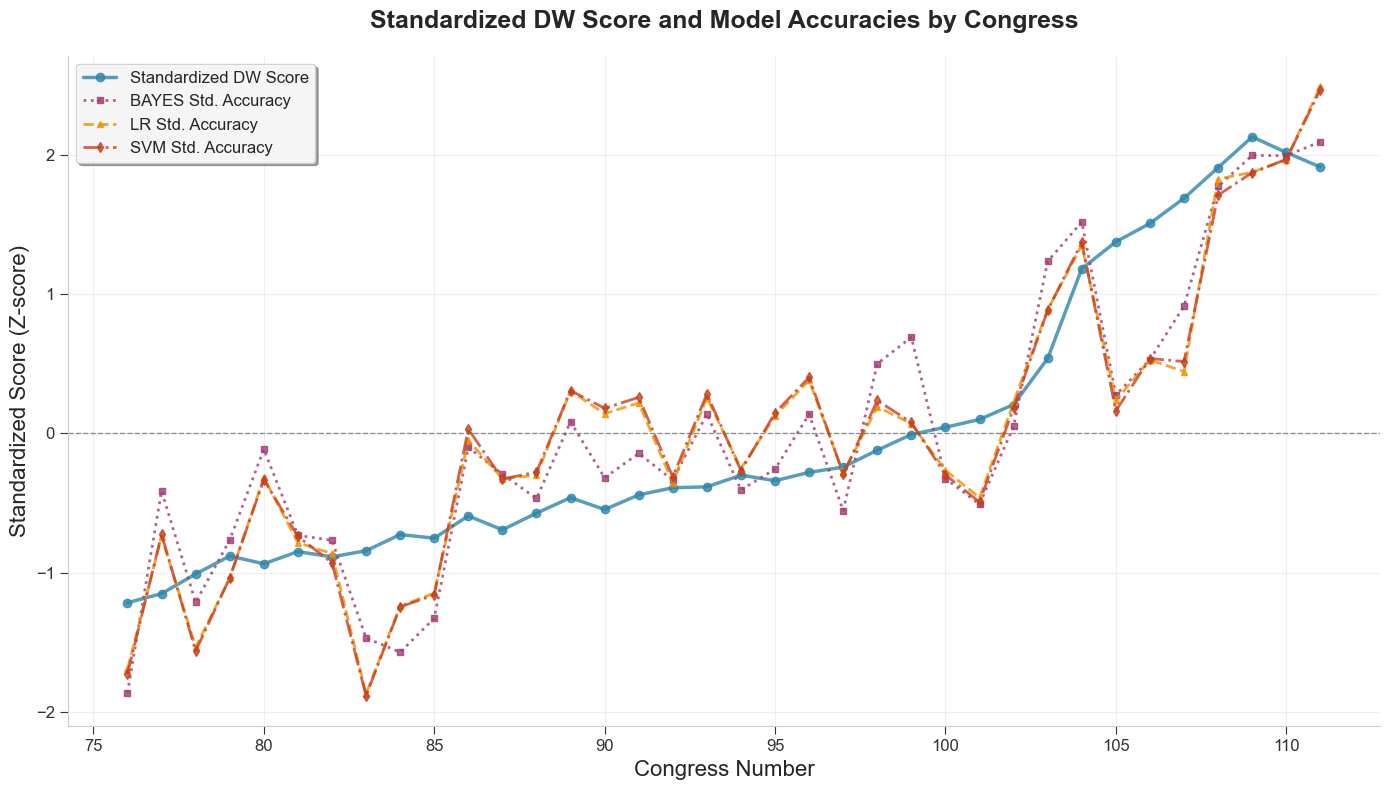

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
plt.style.use('seaborn-v0_8-whitegrid')  # or try 'default' if seaborn not available
sns.set_palette("husl")  # More distinct, appealing colors

plt.figure(figsize=(14, 8))  # Slightly larger for better spacing

# Define a refined color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']
linestyles = ['-', ':', '--', '-.']

# Plot the standardized DW score with refined styling
plt.plot(
    weighted_sum["Congress Number"],
    standard_dw_score,
    color=colors[0],
    marker=markers[0],
    markersize=6,
    linewidth=2.5,
    linestyle=linestyles[0],
    label="Standardized DW Score",
    alpha=0.8
)

# Plot the standardized accuracy for each model with consistent styling
for i, model_name in enumerate(models):
    if i < len(standardize_accuracy):
        model_acc_scores = standardize_accuracy[i]
        plt.plot(
            weighted_sum["Congress Number"],
            model_acc_scores,
            color=colors[(i+1) % len(colors)],
            marker=markers[(i+1) % len(markers)],
            markersize=5,
            linewidth=2,
            linestyle=linestyles[(i+1) % len(linestyles)],
            label=f"{model_name.upper()} Std. Accuracy",
            alpha=0.8
        )
    else:
        print(f"Warning: Missing accuracy data for model index {i} ({model_name}). Skipping plot for this model.")

# Refined styling
plt.xlabel("Congress Number", fontsize=16, fontweight='medium')
plt.ylabel("Standardized Score (Z-score)", fontsize=16, fontweight='medium')
plt.title("Standardized DW Score and Model Accuracies by Congress", 
          fontsize=18, fontweight='bold', pad=20)

# Improved reference line
plt.axhline(0, color='#666666', linestyle='--', linewidth=1, alpha=0.7)

# Better legend styling
plt.legend(frameon=True, fancybox=True, shadow=True, 
          loc='upper left', fontsize=12, framealpha=0.9)

# Refined grid
plt.grid(True, alpha=0.3, linewidth=0.8)

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Improve tick styling
plt.tick_params(axis='both', which='major', labelsize=12, 
                length=6, width=0.8, colors='#333333')

plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import numpy as np

# Calculate average accuracy for each congress
congress_numbers = weighted_sum["Congress Number"]
avg_accuracies = []

for i in range(len(congress_numbers)):
    # Get accuracy for each model at this congress
    accuracies = []
    for model_acc in standardize_accuracy:
        if i < len(model_acc):
            accuracies.append(model_acc[i])
    
    # Calculate average accuracy for this congress
    if accuracies:
        avg_accuracies.append(np.mean(accuracies))
    else:
        avg_accuracies.append(0)

# Create simple dataframe
df = pd.DataFrame({
    'Congress': congress_numbers,
    'Average_Accuracy': avg_accuracies
})

# Sort by accuracy
df_sorted = df.sort_values('Average_Accuracy', ascending=False)

# Get top 5 and bottom 5
top_5 = df_sorted.head(5)
bottom_5 = df_sorted.tail(5)

print("TOP 5 MOST POLARIZED CONGRESSES (Highest Accuracy):")
print(top_5.to_string(index=False))

print("\nBOTTOM 5 LEAST POLARIZED CONGRESSES (Lowest Accuracy):")
print(bottom_5.to_string(index=False))

TOP 5 MOST POLARIZED CONGRESSES (Highest Accuracy):
 Congress  Average_Accuracy
      111          2.353071
      110          1.976220
      109          1.915937
      108          1.771498
      104          1.414603

BOTTOM 5 LEAST POLARIZED CONGRESSES (Lowest Accuracy):
 Congress  Average_Accuracy
       85         -1.211463
       84         -1.352997
       78         -1.437671
       83         -1.741707
       76         -1.761059


# Cosing similarity

cosin similarity between models accuracy and DW-DOMINATE score

=== COSINE SIMILARITY RESULTS (Manual) ===
DW Score vs BAYES: 0.8692
DW Score vs LR: 0.8539
DW Score vs SVM: 0.8468

=== COSINE SIMILARITY RESULTS (sklearn) ===
DW Score vs BAYES: 0.8692
DW Score vs LR: 0.8539
DW Score vs SVM: 0.8468

=== SIMILARITY RANKING ===
1. BAYES: 0.8692
2. LR: 0.8539
3. SVM: 0.8468

=== INTERPRETATION ===
BAYES: Very Strong similarity (Same direction) - 0.8692
LR: Very Strong similarity (Same direction) - 0.8539
SVM: Very Strong similarity (Same direction) - 0.8468

=== SUMMARY TABLE ===
Model  Cosine_Similarity  Rank
BAYES           0.869158     1
   LR           0.853876     2
  SVM           0.846845     3


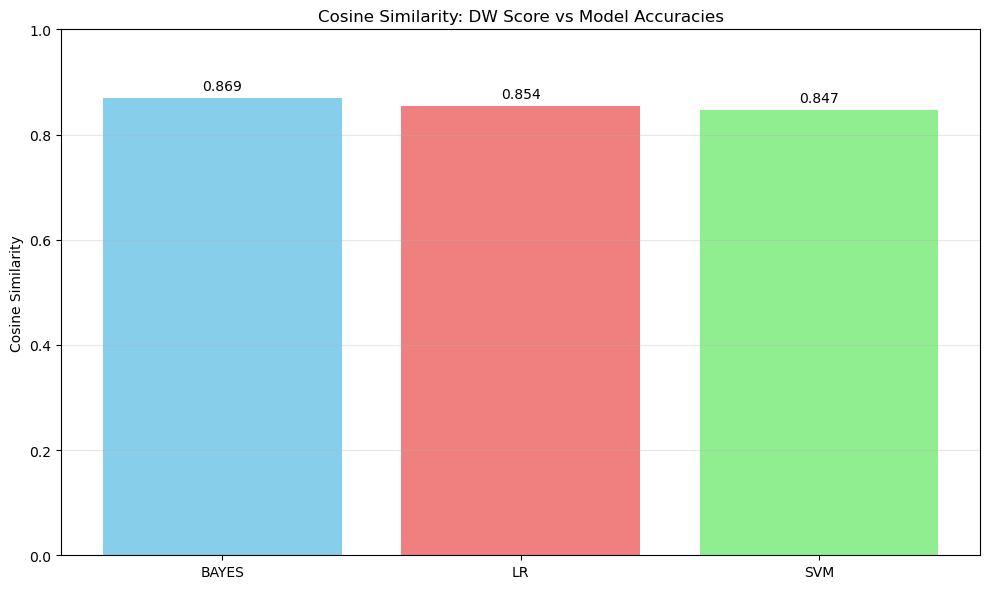


Highest similarity: 0.8692
Lowest similarity: 0.8468
Range: 0.0223


In [ ]:
# =============================================================================
# COSINE SIMILARITY IMPLEMENTATION
# =============================================================================

def calculate_cosine_similarity_manual(series1, series2):
    """
    Calculate cosine similarity manually between two time series
    """
    # Convert to numpy arrays
    a = np.array(series1)
    b = np.array(series2)
    
    # Calculate dot product
    dot_product = np.dot(a, b)
    
    # Calculate magnitudes (norms)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    # Calculate cosine similarity
    cosine_sim = dot_product / (norm_a * norm_b)
    
    return cosine_sim

# Method 1: Manual calculation
print("=== COSINE SIMILARITY RESULTS (Manual) ===")
cosine_results_manual = {}

for i, model in enumerate(models):
    similarity = calculate_cosine_similarity_manual(standard_dw_score, standardize_accuracy[i])
    cosine_results_manual[model] = similarity
    print(f"DW Score vs {model.upper()}: {similarity:.4f}")

print("\n" + "="*50)

# Method 2: Using sklearn (alternative approach)
print("=== COSINE SIMILARITY RESULTS (sklearn) ===")

# Reshape for sklearn (needs 2D arrays)
dw_score_2d = np.array(standard_dw_score).reshape(1, -1)
cosine_results_sklearn = {}

for i, model in enumerate(models):
    accuracy_2d = standardize_accuracy[i].reshape(1, -1)
    similarity = cosine_similarity(dw_score_2d, accuracy_2d)[0][0]
    cosine_results_sklearn[model] = similarity
    print(f"DW Score vs {model.upper()}: {similarity:.4f}")

print("\n" + "="*50)

# =============================================================================
# RESULTS ANALYSIS
# =============================================================================

print("=== SIMILARITY RANKING ===")
# Sort models by similarity (highest first)
sorted_models = sorted(cosine_results_manual.items(), key=lambda x: x[1], reverse=True)

for rank, (model, similarity) in enumerate(sorted_models, 1):
    print(f"{rank}. {model.upper()}: {similarity:.4f}")

print("\n=== INTERPRETATION ===")
for model, similarity in cosine_results_manual.items():
    if similarity > 0.8:
        strength = "Very Strong"
    elif similarity > 0.6:
        strength = "Strong"
    elif similarity > 0.4:
        strength = "Moderate"
    elif similarity > 0.2:
        strength = "Weak"
    else:
        strength = "Very Weak"
    
    direction = "Same direction" if similarity > 0 else "Opposite direction"
    print(f"{model.upper()}: {strength} similarity ({direction}) - {similarity:.4f}")

# =============================================================================
# CREATE SUMMARY DATAFRAME
# =============================================================================

summary_df = pd.DataFrame({
    'Model': [model.upper() for model in models],
    'Cosine_Similarity': [cosine_results_manual[model] for model in models],
    'Rank': range(1, len(models) + 1)
})

# Sort by similarity
summary_df = summary_df.sort_values('Cosine_Similarity', ascending=False).reset_index(drop=True)
summary_df['Rank'] = range(1, len(summary_df) + 1)

print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False))

# =============================================================================
# OPTIONAL: VISUALIZE SIMILARITIES
# =============================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
models_upper = [model.upper() for model in models]
similarities = [cosine_results_manual[model] for model in models]

bars = plt.bar(models_upper, similarities, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity: DW Score vs Model Accuracies')
plt.ylim(0, 1)

# Add value labels on bars
for bar, sim in zip(bars, similarities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{sim:.3f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHighest similarity: {max(similarities):.4f}")

print(f"Lowest similarity: {min(similarities):.4f}")
print(f"Range: {max(similarities) - min(similarities):.4f}")

In [22]:
# Load the data
import pandas as pd
import numpy as np
from pathlib import Path

models = ["bayes", "lr", "svm"]
base_dir = Path("../logs")
data = {}

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    data[model] = pd.read_csv(model_file)

# Create combined dataframe
combined_df = pd.DataFrame()
combined_df['year'] = data['bayes']['year']

for model in models:
    combined_df[f'{model}_accuracy'] = data[model]['accuracy']
    combined_df[f'{model}_f1_score'] = data[model]['f1_score']

# Filter for most imbalanced congresses
imbalanced_congresses = [92, 86, 94]
imbalanced_df = combined_df[combined_df['year'].isin(imbalanced_congresses)]

# Create comparison table
comparison_table = pd.DataFrame(index=['BAYES', 'LR', 'SVM'])

# Calculate average accuracy and F1-score for each model
for model in models:
    avg_accuracy = imbalanced_df[f'{model}_accuracy'].mean()
    avg_f1_score = imbalanced_df[f'{model}_f1_score'].mean()
    
    comparison_table.loc[model.upper(), 'Average Accuracy'] = avg_accuracy
    comparison_table.loc[model.upper(), 'Average F1-Score'] = avg_f1_score
    comparison_table.loc[model.upper(), 'Difference (Acc - F1)'] = avg_accuracy - avg_f1_score

print("ACCURACY vs F1-SCORE COMPARISON FOR IMBALANCED CONGRESSES (92, 86, 94)")
print("=" * 75)
print(comparison_table.round(4))

ACCURACY vs F1-SCORE COMPARISON FOR IMBALANCED CONGRESSES (92, 86, 94)
       Average Accuracy  Average F1-Score  Difference (Acc - F1)
BAYES            0.6241            0.5533                 0.0708
LR               0.6258            0.5811                 0.0447
SVM              0.6075            0.5939                 0.0136


In [14]:
# Load the data
import pandas as pd
import numpy as np
from pathlib import Path

models = ["bayes", "lr", "svm"]
base_dir = Path("../logs")
data = {}

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    data[model] = pd.read_csv(model_file)

# Create combined dataframe
combined_df = pd.DataFrame()
combined_df['year'] = data['bayes']['year']

for model in models:
    combined_df[f'{model}_accuracy'] = data[model]['accuracy']
    combined_df[f'{model}_f1_score'] = data[model]['f1_score']

# Create comparison table for overall performance
comparison_table = pd.DataFrame(index=['BAYES', 'LR', 'SVM'])

# Calculate average accuracy and F1-score for each model across all congresses
for model in models:
    avg_accuracy = combined_df[f'{model}_accuracy'].mean()
    avg_f1_score = combined_df[f'{model}_f1_score'].mean()
    
    comparison_table.loc[model.upper(), 'Average Accuracy'] = avg_accuracy
    comparison_table.loc[model.upper(), 'Average F1-Score'] = avg_f1_score
    comparison_table.loc[model.upper(), 'Difference (Acc - F1)'] = avg_accuracy - avg_f1_score

print("OVERALL ACCURACY vs F1-SCORE COMPARISON")
print("=" * 50)
print(comparison_table.round(4))

OVERALL ACCURACY vs F1-SCORE COMPARISON
       Average Accuracy  Average F1-Score  Difference (Acc - F1)
BAYES            0.6179            0.6006                 0.0173
LR               0.6365            0.6273                 0.0092
SVM              0.6318            0.6308                 0.0010


OVERALL ACCURACY vs F1-SCORE COMPARISON (Ordered by F1-Score)
       Average Accuracy  Average F1-Score  Difference (Acc - F1)
SVM              0.6318            0.6308                 0.0010
LR               0.6365            0.6273                 0.0092
BAYES            0.6179            0.6006                 0.0173


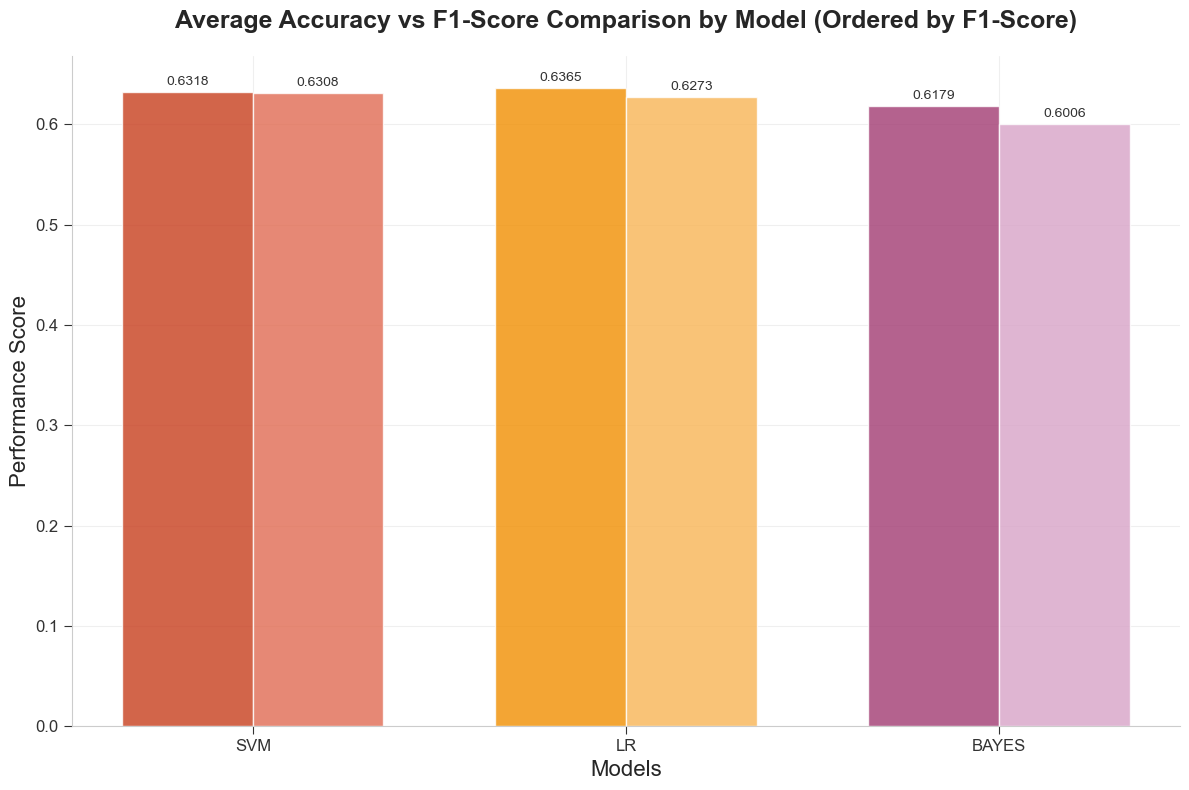

In [ ]:
# Load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

models = ["bayes", "lr", "svm"]
base_dir = Path("../logs")
data = {}

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    data[model] = pd.read_csv(model_file)

# Create combined dataframe
combined_df = pd.DataFrame()
combined_df['year'] = data['bayes']['year']
for model in models:
    combined_df[f'{model}_accuracy'] = data[model]['accuracy']
    combined_df[f'{model}_f1_score'] = data[model]['f1_score']

# Create comparison table for overall performance
comparison_table = pd.DataFrame(index=['BAYES', 'LR', 'SVM'])

# Calculate average accuracy and F1-score for each model across all congresses
for model in models:
    avg_accuracy = combined_df[f'{model}_accuracy'].mean()
    avg_f1_score = combined_df[f'{model}_f1_score'].mean()
    
    comparison_table.loc[model.upper(), 'Average Accuracy'] = avg_accuracy
    comparison_table.loc[model.upper(), 'Average F1-Score'] = avg_f1_score
    comparison_table.loc[model.upper(), 'Difference (Acc - F1)'] = avg_accuracy - avg_f1_score

# Sort by F1-Score in descending order (highest first)
comparison_table_sorted = comparison_table.sort_values('Average F1-Score', ascending=False)

print("OVERALL ACCURACY vs F1-SCORE COMPARISON (Ordered by F1-Score)")
print("=" * 60)
print(comparison_table_sorted.round(4))

# Set consistent styling to match the previous plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create histogram plot with matching aesthetics
fig, ax = plt.subplots(figsize=(12, 8))

# Use the same color palette as the previous plot
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Create mapping of original model names to colors
model_color_map = {
    'BAYES': (colors[1], '#D8A3C7'),  # A23B72 and lighter version
    'LR': (colors[2], '#F8B555'),     # F18F01 and lighter version  
    'SVM': (colors[3], '#E06B52')     # C73E1D and lighter version
}

# Get ordered model names and their corresponding colors
ordered_models = comparison_table_sorted.index.tolist()
ordered_model_colors = [model_color_map[model][0] for model in ordered_models]
ordered_model_colors_light = [model_color_map[model][1] for model in ordered_models]

x = np.arange(len(ordered_models))
width = 0.35

# Get values for plotting (now in sorted order)
accuracy_values = comparison_table_sorted['Average Accuracy'].values
f1_values = comparison_table_sorted['Average F1-Score'].values

# Create bars with model-specific colors
bars1 = ax.bar(x - width/2, accuracy_values, width, 
               label='Average Accuracy', 
               color=ordered_model_colors, alpha=0.8, edgecolor='white', linewidth=1)
bars2 = ax.bar(x + width/2, f1_values, width, 
               label='Average F1-Score', 
               color=ordered_model_colors_light, alpha=0.8, edgecolor='white', linewidth=1)

# Customize the plot with matching style
ax.set_xlabel('Models', fontsize=16, fontweight='medium')
ax.set_ylabel('Performance Score', fontsize=16, fontweight='medium')
ax.set_title('Average Accuracy vs F1-Score Comparison by Model ', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(ordered_models, fontsize=14)


# Refined grid to match
ax.grid(True, alpha=0.3, linewidth=0.8)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Improve tick styling
ax.tick_params(axis='both', which='major', labelsize=12, 
               length=6, width=0.8, colors='#333333')

# Add value labels on bars with improved styling
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, 
                fontweight='medium', color='#333333')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10,
                fontweight='medium', color='#333333')

plt.tight_layout()
plt.show()


BAYES - Congress 94:
  Confusion Matrix:
    TN: 4207, FP: 575
    FN: 2646, TP: 627
  Accuracy: 0.6001
  Precision: 0.5216
  Recall: 0.1916
  F1-Score: 0.2802

LR - Congress 94:
  Confusion Matrix:
    TN: 4237, FP: 545
    FN: 2521, TP: 752
  Accuracy: 0.6194
  Precision: 0.5798
  Recall: 0.2298
  F1-Score: 0.3291

SVM - Congress 94:
  Confusion Matrix:
    TN: 3825, FP: 957
    FN: 2160, TP: 1113
  Accuracy: 0.6130
  Precision: 0.5377
  Recall: 0.3401
  F1-Score: 0.4166


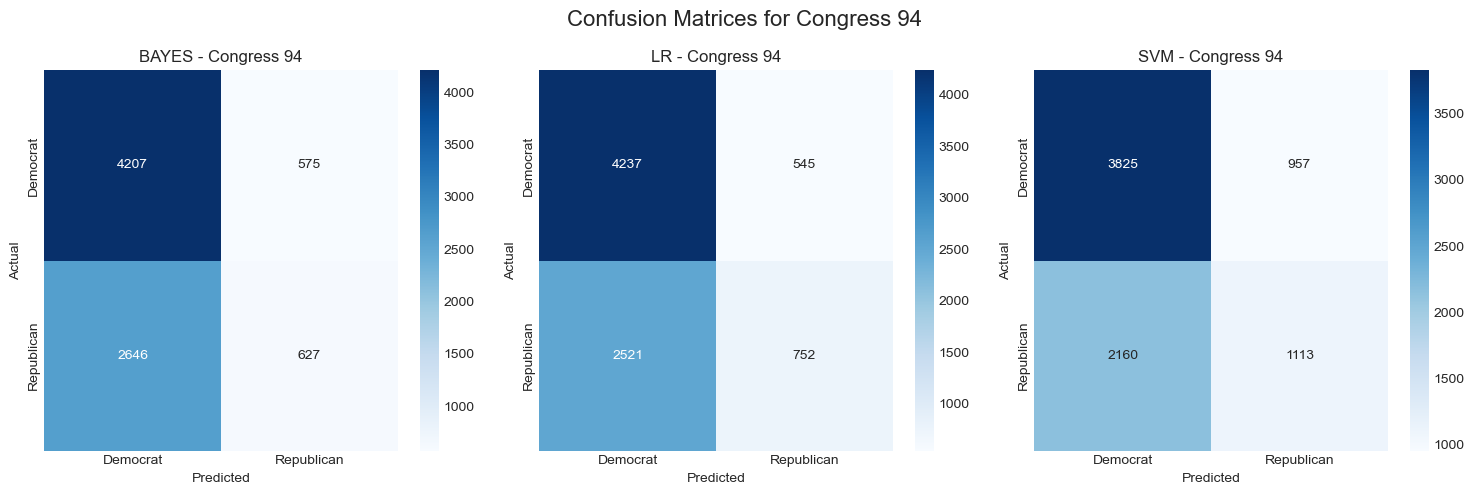


BAYES - Congress 103:
  Confusion Matrix:
    TN: 1765, FP: 1000
    FN: 883, TP: 2029
  Accuracy: 0.6683
  Precision: 0.6699
  Recall: 0.6968
  F1-Score: 0.6830

LR - Congress 103:
  Confusion Matrix:
    TN: 1968, FP: 798
    FN: 983, TP: 1929
  Accuracy: 0.6863
  Precision: 0.7074
  Recall: 0.6624
  F1-Score: 0.6842

SVM - Congress 103:
  Confusion Matrix:
    TN: 1934, FP: 831
    FN: 963, TP: 1949
  Accuracy: 0.6840
  Precision: 0.7011
  Recall: 0.6693
  F1-Score: 0.6848


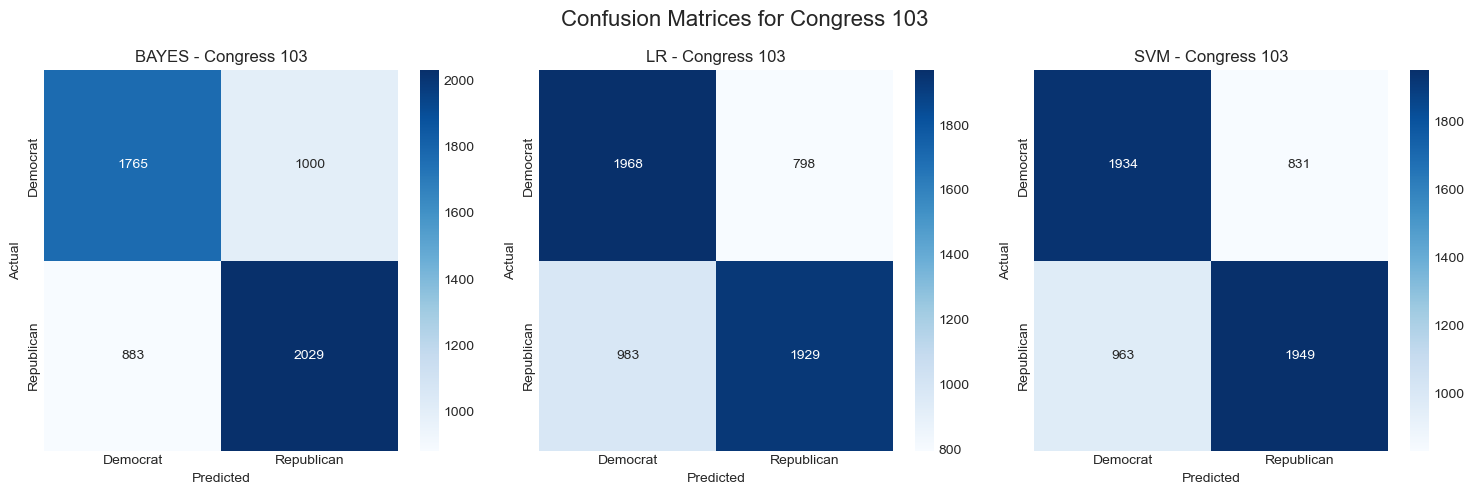


CONFUSION MATRIX SUMMARY FOR POLARIZED CONGRESSES
   Congress  Model    TN    FP    FN    TP  Total  Accuracy
0        94  BAYES  4207   575  2646   627   8055    0.6001
1        94     LR  4237   545  2521   752   8055    0.6194
2        94    SVM  3825   957  2160  1113   8055    0.6130
3       103  BAYES  1765  1000   883  2029   5677    0.6683
4       103     LR  1968   798   983  1929   5678    0.6863
5       103    SVM  1934   831   963  1949   5677    0.6840


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define models and polarized congresses
models = ["bayes", "lr", "svm"]
polarized_congresses = [94, 103]
base_dir = Path("../logs")

# Function to create confusion matrix from TP, TN, FP, FN
def create_confusion_matrix(tn, fp, fn, tp):
    """Create confusion matrix from confusion matrix components"""
    return np.array([[tn, fp], 
                     [fn, tp]])

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model, congress, ax):
    """Plot confusion matrix with labels"""
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Democrat', 'Republican'],
                yticklabels=['Democrat', 'Republican'])
    ax.set_title(f'{model.upper()} - Congress {congress}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Load data and compute averaged confusion matrices
confusion_matrices = {}

# Create separate plots for each congress
for congress in polarized_congresses:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Confusion Matrices for Congress {congress}', fontsize=16)
    
    for j, model in enumerate(models):
        # Load detailed results for each model
        model_file = base_dir / f"tfidf_{model}_performance_detailed.csv"
        df = pd.read_csv(model_file)
        
        # Filter for specific congress
        congress_data = df[df['year'] == congress]
        
        if len(congress_data) == 0:
            print(f"Warning: No data found for {model} in Congress {congress}")
            continue
        
        # Calculate average confusion matrix components across all seeds
        avg_tn = congress_data['tn'].mean()
        avg_fp = congress_data['fp'].mean()
        avg_fn = congress_data['fn'].mean()
        avg_tp = congress_data['tp'].mean()
        
        # Round to nearest integer for confusion matrix
        avg_tn = int(round(avg_tn))
        avg_fp = int(round(avg_fp))
        avg_fn = int(round(avg_fn))
        avg_tp = int(round(avg_tp))
        
        # Create confusion matrix
        cm = create_confusion_matrix(avg_tn, avg_fp, avg_fn, avg_tp)
        
        # Store for later use
        confusion_matrices[f'{model}_{congress}'] = cm
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, model, congress, axes[j])
        
        # Print summary statistics
        total_predictions = avg_tn + avg_fp + avg_fn + avg_tp
        accuracy = (avg_tp + avg_tn) / total_predictions
        precision = avg_tp / (avg_tp + avg_fp) if (avg_tp + avg_fp) > 0 else 0
        recall = avg_tp / (avg_tp + avg_fn) if (avg_tp + avg_fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n{model.upper()} - Congress {congress}:")
        print(f"  Confusion Matrix:")
        print(f"    TN: {avg_tn}, FP: {avg_fp}")
        print(f"    FN: {avg_fn}, TP: {avg_tp}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
    
    plt.tight_layout()
    plt.show()

# Create summary table
print("\n" + "="*80)
print("CONFUSION MATRIX SUMMARY FOR POLARIZED CONGRESSES")
print("="*80)

summary_data = []
for congress in polarized_congresses:
    for model in models:
        key = f'{model}_{congress}'
        if key in confusion_matrices:
            cm = confusion_matrices[key]
            tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
            total = tn + fp + fn + tp
            accuracy = (tp + tn) / total
            
            summary_data.append({
                'Congress': congress,
                'Model': model.upper(),
                'TN': tn,
                'FP': fp, 
                'FN': fn,
                'TP': tp,
                'Total': total,
                'Accuracy': accuracy
            })

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4))